In [2]:
import numpy as np
from typing import List, Union, Tuple, Optional
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


def ncon(tensors: List[np.ndarray],
         connects: List[Union[List[int], Tuple[int]]],
         con_order: Optional[Union[List[int], str]] = None,
         check_network: Optional[bool] = True,
         which_env: Optional[int] = 0):
  """
  Network CONtractor: contracts a tensor network of N tensors via a sequence
  of (N-1) tensordot operations. More detailed instructions and examples can
  be found at: https://arxiv.org/abs/1402.0939.
  Args:
    tensors: list of the tensors in the network.
    connects: length-N list of lists (or tuples) specifying the network
      connections. The jth entry of the ith list in connects labels the edge
      connected to the jth index of the ith tensor. Labels should be positive
      integers for internal indices and negative integers for free indices.
    con_order: optional argument to specify the order for contracting the
      positive indices. Defaults to ascending order if omitted. Can also be
      set at "greedy" or "full" to call a solver to automatically determine
      the order.
    check_network: if true then the input network is checked for consistency;
      this can catch many common user mistakes for defining networks.
    which_env: if provided, ncon will produce the environment of the requested
      tensor (i.e. the network given by removing the specified tensor from
      the original network). Only valid for networks with no open indices.
  Returns:
    Union[np.ndarray,float]: the result of the network contraction; an
      np.ndarray if the network contained open indices, otherwise a scalar.
  """
  num_tensors = len(tensors)
  tensor_list = [tensors[ele] for ele in range(num_tensors)]
  connect_list = [np.array(connects[ele]) for ele in range(num_tensors)]

  # generate contraction order if necessary
  flat_connect = np.concatenate(connect_list)
  if con_order is None:
    con_order = np.unique(flat_connect[flat_connect > 0])
  else:
    con_order = np.array(con_order)

  # check inputs if enabled
  if check_network:
    dims_list = [list(tensor.shape) for tensor in tensor_list]
    check_inputs(connect_list, flat_connect, dims_list, con_order)

  # do all partial traces
  for ele in range(len(tensor_list)):
    num_cont = len(connect_list[ele]) - len(np.unique(connect_list[ele]))
    if num_cont > 0:
      tensor_list[ele], connect_list[ele], cont_ind = partial_trace(
          tensor_list[ele], connect_list[ele])
      con_order = np.delete(
          con_order,
          np.intersect1d(con_order, cont_ind, return_indices=True)[1])

  # do all binary contractions
  while len(con_order) > 0:
    # identify tensors to be contracted
    cont_ind = con_order[0]
    locs = [
        ele for ele in range(len(connect_list))
        if sum(connect_list[ele] == cont_ind) > 0
    ]

    # do binary contraction
    cont_many, A_cont, B_cont = np.intersect1d(
        connect_list[locs[0]],
        connect_list[locs[1]],
        assume_unique=True,
        return_indices=True)
    if np.size(tensor_list[locs[0]]) < np.size(tensor_list[locs[1]]):
      ind_order = np.argsort(A_cont)
    else:
      ind_order = np.argsort(B_cont)

    tensor_list.append(
        np.tensordot(
            tensor_list[locs[0]],
            tensor_list[locs[1]],
            axes=(A_cont[ind_order], B_cont[ind_order])))
    connect_list.append(
        np.append(
            np.delete(connect_list[locs[0]], A_cont),
            np.delete(connect_list[locs[1]], B_cont)))

    # remove contracted tensors from list and update con_order
    del tensor_list[locs[1]]
    del tensor_list[locs[0]]
    del connect_list[locs[1]]
    del connect_list[locs[0]]
    con_order = np.delete(
        con_order,
        np.intersect1d(con_order, cont_many, return_indices=True)[1])

  # do all outer products
  while len(tensor_list) > 1:
    s1 = tensor_list[-2].shape
    s2 = tensor_list[-1].shape
    tensor_list[-2] = np.outer(tensor_list[-2].reshape(np.prod(s1)),
                               tensor_list[-1].reshape(np.prod(s2))).reshape(
                                   np.append(s1, s2))
    connect_list[-2] = np.append(connect_list[-2], connect_list[-1])
    del tensor_list[-1]
    del connect_list[-1]

  # do final permutation
  if len(connect_list[0]) > 0:
    return np.transpose(tensor_list[0], np.argsort(-connect_list[0]))
  else:
    return tensor_list[0].item()


def partial_trace(A, A_label):
  """ Partial trace on tensor A over repeated labels in A_label """

  num_cont = len(A_label) - len(np.unique(A_label))
  if num_cont > 0:
    dup_list = []
    for ele in np.unique(A_label):
      if sum(A_label == ele) > 1:
        dup_list.append([np.where(A_label == ele)[0]])

    cont_ind = np.array(dup_list).reshape(2 * num_cont, order='F')
    free_ind = np.delete(np.arange(len(A_label)), cont_ind)

    cont_dim = np.prod(np.array(A.shape)[cont_ind[:num_cont]])
    free_dim = np.array(A.shape)[free_ind]

    B_label = np.delete(A_label, cont_ind)
    cont_label = np.unique(A_label[cont_ind])
    B = np.zeros(np.prod(free_dim))
    A = A.transpose(np.append(free_ind, cont_ind)).reshape(
        np.prod(free_dim), cont_dim, cont_dim)
    for ip in range(cont_dim):
      B = B + A[:, ip, ip]

    return B.reshape(free_dim), B_label, cont_label

  else:
    return A, A_label, []


def check_inputs(connect_list, flat_connect, dims_list, con_order):
  """ Check consistancy of NCON inputs"""

  pos_ind = flat_connect[flat_connect > 0]
  neg_ind = flat_connect[flat_connect < 0]

  # check that lengths of lists match
  if len(dims_list) != len(connect_list):
    raise ValueError(
        ('mismatch between %i tensors given but %i index sublists given') %
        (len(dims_list), len(connect_list)))

  # check that tensors have the right number of indices
  for ele in range(len(dims_list)):
    if len(dims_list[ele]) != len(connect_list[ele]):
      raise ValueError((
          'number of indices does not match number of labels on tensor %i: '
          '%i-indices versus %i-labels')
          % (ele, len(dims_list[ele]), len(connect_list[ele])))

  # check that contraction order is valid
  if not np.array_equal(np.sort(con_order), np.unique(pos_ind)):
    raise ValueError(('NCON error: invalid contraction order'))

  # check that negative indices are valid
  for ind in np.arange(-1, -len(neg_ind) - 1, -1):
    if sum(neg_ind == ind) == 0:
      raise ValueError(('NCON error: no index labelled %i') % (ind))
    elif sum(neg_ind == ind) > 1:
      raise ValueError(('NCON error: more than one index labelled %i') % (ind))

  # check that positive indices are valid and contracted tensor dimensions match
  flat_dims = np.array([item for sublist in dims_list for item in sublist])
  for ind in np.unique(pos_ind):
    if sum(pos_ind == ind) == 1:
      raise ValueError(('NCON error: only one index labelled %i') % (ind))
    elif sum(pos_ind == ind) > 2:
      raise ValueError(
          ('NCON error: more than two indices labelled %i') % (ind))

    cont_dims = flat_dims[flat_connect == ind]
    if cont_dims[0] != cont_dims[1]:
      raise ValueError(
          ('NCON error: tensor dimension mismatch on index labelled %i: '
           'dim-%i versus dim-%i') % (ind, cont_dims[0], cont_dims[1]))

  return True

In [3]:
import numpy as np
from numpy import linalg as LA
from scipy.linalg import expm, norm
from scipy.sparse.linalg import LinearOperator, eigs
# from ncon import ncon
from typing import Optional

In [4]:
def Sample(MPS_,state):
    for i in range (len(state)):
        A=MPS_[i]
        chi_l,_,chi_r=A.shape
        MPS_[i]=A[:,int(state[i]),:].reshape(chi_l,chi_r)
        # print(MPS[i].shape,int(state[i]))
    # print(MPS)
    amplitude=ncon([MPS_[0],MPS_[1]],[[-1,1],[1,-2]])
    for i in range(2,len(state)):
        amplitude=ncon([amplitude,MPS_[i]],[[-1,1],[1,-2]])
    return amplitude.reshape([1])[0]

In [5]:
def vidal_form(mps):
    mps=mps.copy()
    vidal_form = []
    A = mps[0]
    chi_L,_,chi_R=A.shape
    A_=A.reshape(chi_L*d,chi_R)
    # Perform SVD on A
    print(A_.shape)
    utemp, stemp, vhtemp = np.linalg.svd(A_, full_matrices=False)
    print(norm(np.conj(utemp.T)@utemp),np.linalg.norm(vhtemp),np.linalg.norm(stemp))
    print(utemp.shape,stemp.shape,vhtemp.shape)
    chitemp = min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
    vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R) # no change during reshape
    stemp=stemp[range(chitemp)]
    # stemp=stemp/np.linalg.norm(stemp)
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)

    print(np.linalg.norm(utemp),np.linalg.norm(vhtemp))
    
    vidal_form.append(utemp)
    vidal_form.append(stemp)

    # Process the remaining tensors
    for i in range(1, len(mps) - 1):
        B = mps[i]
        # print(B.shape)
        # print(np.linalg.norm(B.ravel()),np.linalg.norm(vhtemp.ravel()),norm((vhtemp@B).ravel()))
        B=ncon([vhtemp,B],[[-1,1],[1,-2,-3]])
        # print(np.linalg.norm(B))
        chi_L,_,chi_R=B.shape
        # print(B.shape)
        B_=B.reshape(chi_L*d,chi_R)
        # Contract B with the previous gamma matrix
        
        
        # Perform SVD on the reshaped tensor
        utemp, stemp, vhtemp = np.linalg.svd(B_, full_matrices=False)
        
        chitemp = min(chi, len(stemp))
        utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
        vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R)
        stemp=stemp[range(chitemp)]
        # stemp=stemp/np.linalg.norm(stemp)
        stemp=stemp.astype(np.complex64)
        vhtemp=vhtemp.astype(np.complex64)
        utemp=utemp.astype(np.complex64)
        
        vidal_form.append(utemp)
        vidal_form.append(stemp)
        
    # Process the last tensor (E)
    Z = mps[-1]
    print(np.linalg.norm(Z),np.linalg.norm(vhtemp))
    Z=ncon([vhtemp,Z],[[-1,1],[1,-2,-3]])
    chi_L,_,chi_R=Z.shape
    print(Z.shape)
    Z_=Z.reshape(chi_L*d,chi_R)
    print(np.linalg.norm(Z))
    
    utemp, stemp, vhtemp = np.linalg.svd(Z_, full_matrices=False)
    # Z_=utemp

    chitemp = len(stemp)#min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)]
    vhtemp = vhtemp[range(chitemp), :]
    stemp=stemp[range(chitemp)]
    # stemp=stemp/np.linalg.norm(stemp)
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)

    print("check",stemp,vhtemp)
    
    Z_=utemp@np.diag(stemp)@vhtemp
    print(np.linalg.norm(Z_))
    print(utemp.shape,stemp.shape,vhtemp.shape)
    print(Z_.shape)
    vhtemp=Z_.reshape(chi_L,d,chi_R)
    
    vidal_form.append(vhtemp)

    return vidal_form

def left_canonical_form(mps):
    mps=mps.copy()
    vidal_form = []
    SS=[]
    A = mps[0]
    chi_L,_,chi_R=A.shape
    A_=A.reshape(chi_L*d,chi_R)
    # Perform SVD on A
    # print(A_.shape)
    utemp, stemp, vhtemp = np.linalg.svd(A_, full_matrices=False)
    # print(utemp.shape,stemp.shape,vhtemp.shape)
    chitemp = min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
    vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R) # no change during reshape
    stemp=stemp[range(chitemp)]
    stemp=stemp/np.linalg.norm(stemp)
    SS.append(stemp)
    vhtemp=np.diag(stemp)@vhtemp
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)
    
    vidal_form.append(utemp)
    
    # Process the remaining tensors
    for i in range(1, len(mps) - 1):
        B = mps[i]
        # print(B.shape)
        B=ncon([vhtemp,B],[[-1,1],[1,-2,-3]])
        chi_L,_,chi_R=B.shape
        # print(B.shape,np.linalg.norm(stemp))
        B_=B.reshape(chi_L*d,chi_R)
        # Contract B with the previous gamma matrix
        
        
        # Perform SVD on the reshaped tensor
        utemp, stemp, vhtemp = np.linalg.svd(B_, full_matrices=False)
        
        chitemp = min(chi, len(stemp))
        utemp = utemp[:, range(chitemp)].reshape(chi_L,d,chitemp)
        vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R)
        stemp=stemp[range(chitemp)]
        stemp=stemp/np.linalg.norm(stemp)
        SS.append(stemp)
        vhtemp=np.diag(stemp)@vhtemp
        stemp=stemp.astype(np.complex64)
        vhtemp=vhtemp.astype(np.complex64)
        utemp=utemp.astype(np.complex64)
        
        vidal_form.append(utemp)
        
    # Process the last tensor (E)
    Z = mps[-1]
    Z=ncon([vhtemp,Z],[[-1,1],[1,-2,-3]])
    chi_L,_,chi_R=Z.shape
    # print(Z.shape)
    Z_=Z.reshape(chi_L*d,chi_R)
    
    utemp, stemp, vhtemp = np.linalg.svd(Z_, full_matrices=False)
    # Z_=utemp

    chitemp = len(stemp)#min(chi, len(stemp))
    utemp = utemp[:, range(chitemp)]
    vhtemp = vhtemp[range(chitemp), :]
    stemp=stemp[range(chitemp)]
    stemp=stemp/np.linalg.norm(stemp)
    SS.append(stemp)
    stemp=stemp.astype(np.complex64)
    vhtemp=vhtemp.astype(np.complex64)
    utemp=utemp.astype(np.complex64)
    
    print("check",stemp,vhtemp)
    
    Z_=utemp@np.diag(stemp)@vhtemp
    # print(utemp.shape,stemp.shape,vhtemp.shape)
    # print(Z_.shape)
    vhtemp=Z_.reshape(chi_L,d,chi_R)

    vidal_form.append(vhtemp)

    return vidal_form, SS

In [6]:
#lenght(MPS) is always odd in canonical form

def get_Gammas(MPS_):
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[0])
    for i in range(1,len(MPS_),2):
        # lambda_=MPS_[i]
        gamma_=MPS_[i+1]
        # print(b.shape)
        # lambda_=np.diag(lambda_)
        # print(b.shape)
        # c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        c=gamma_
        mps.append(c)
    return mps

def vidal_to_left(MPS_):
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[0])
    for i in range(1,len(MPS_),2):
        lambda_=MPS_[i]
        gamma_=MPS_[i+1]
        # print(lambda_,gamma_)
        lambda_=np.diag(lambda_)
        # print(b.shape)
        c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        # print(c)
        mps.append(c)
        # brbg
    return mps

def left_to_vidal(MPS_): # incomplete
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[0])
    for i in range(1,len(MPS_)):
        A=MPS_[i]
        chi_L,_,chi_R=A.shape
        A=A.reshape(chi_L*d,chi_R)
        utemp, stemp, vhtemp = np.linalg.svd(A, full_matrices=False)
        
        utemp = utemp.reshape(chi_L,d,chitemp)
        vhtemp = vhtemp[range(chitemp), :].reshape(chitemp,chi_R)
        # print(lambda_,gamma_)
        lambda_=np.diag(lambda_)
        # print(b.shape)
        c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        # print(c)
        mps.append(c)
        # brbg
    return mps
    

def get_Lambdas(MPS_):
    MPS_=MPS_.copy()
    mps=[]
    mps.append(MPS_[1])
    for i in range(3,len(MPS_),2):
        lambda_=MPS_[i]
        # gamma_=MPS_[i+1]
        # print(b.shape)
        # lambda_=np.diag(lambda_)
        # print(b.shape)
        # c=ncon([lambda_,gamma_],[[-1,1],[1,-2,-3]])
        # c=gamma_
        mps.append(lambda_)
    return mps


def fidelity2(MPS_A,MPS_B):
    MPS_A=MPS_A.copy()
    MPS_B=MPS_B.copy()
    for i in range(len(MPS_B)):
        MPS_B[i]=np.conj(MPS_B[i])
    Norm=ncon([MPS_A[0],MPS_B[0]],[[1,2,-1],[1,2,-2]])
    for i in range(1,len(MPS_A)):
        Norm=ncon([Norm,MPS_A[i],MPS_B[i]],[[1,3],[1,2,-1],[3,2,-2]])
    return (ncon([Norm],[[1,1]]))


In [7]:

def entagelement_entropy3(S):
    S=S.copy()
    entropy=np.zeros([len(S)-1])
    for i in range(len(S)-1):
        # print((MPS_[i]))
        x=S[i][S[i]>1e-20]
        entropy[i]=-np.sum(x**2*np.log(x**2))
    # plt.plot(range(len(S)-1),entropy)
    
    return entropy

In [8]:
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0, -1]])
I=np.array([[1, 0], [0, 1]])
nZ=-0.5*(sZ-I)
Swap=np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).reshape(2, 2, 2, 2)

In [9]:

def apply_gate_MPS_left(A, B, SS, gateAB, stol=1e-7,dont_normalize=0):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""

    SS = SS * (SS > stol) + stol * (SS < stol)
    
    chiA,_,_=A.shape
    _,_,chiB=B.shape
    tensors = [A, B, np.diag(SS), gateAB]
    connects = [[-1, 3, 2], [2, 4, 5], [5,-4], [-2, -3, 3, 4]]
    nshape = [d * chiA, d * chiB]
    utemp, stemp, vhtemp = np.linalg.svd(ncon(tensors, connects).reshape(nshape),full_matrices=False)
    
    # truncate to reduced dimension
    chitemp = min(chi, len(stemp),np.sum(stemp>stol))
    utemp = utemp[:, range(chitemp)].reshape(chiA, d * chitemp)
    vhtemp = vhtemp[range(chitemp), :]
    # print(np.linalg.norm(stemp))
    # print(stemp.shape,'a')
    norm_=np.linalg.norm(stemp)
    if dont_normalize!=0:
        stemp = stemp[range(chitemp)]#/ np.linalg.norm(stemp)*norm_
    else:
        stemp = stemp[range(chitemp)]/ np.linalg.norm(stemp)#*norm_
    # print(stemp.shape,stemp)
    # print(SS.shape,vhtemp.shape,stemp.shape,chiB,vhtemp.reshape(chitemp,d,chiB).shap)
    vhtemp=ncon([np.diag(stemp),vhtemp.reshape(chitemp,d,chiB),np.diag(1/SS)],[[-1,1],[1,-2,2],[2,-3]])
    # vhtemp=(vhtemp).reshape(chitemp * d, chiB)

    # new weights
    
    # remove environment weights to form new MPS tensors A and B
    A = (utemp).reshape(chiA, d, chitemp)
    B = (vhtemp).reshape(chitemp, d, chiB)
    
    return A, stemp, B

def apply_last_gate_MPS_left(A, gateAB, stol=1e-7):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""
    
    chiA,_,chiB=A.shape
    tensors = [A, gateAB]
    connects = [[-1, 1, -3], [1,-2]]
    A=ncon(tensors, connects)
    
    return A

In [10]:
def apply_hamiltonian(MPS_vid,gate,gate_last,odd_even):
    MPS_vid=MPS_vid.copy()
    if odd_even=="even":
        # print("even")
        iniit=0
    else:
        # print("odd")
        iniit=2
    for i in range(iniit,len(MPS_vid)-1,4): # -1 to deal the last state separetly
        if i-1<0:
            sA=np.array([1.0])
        else:
            sA=MPS_vid[i-1]
        A=MPS_vid[i]
        sAB=MPS_vid[i+1]
        B=MPS_vid[i+2]
        if i+3>=len(MPS_vid):
            sB=np.array([1.0])
        else:
            sB=MPS_vid[i+3]
        A,sAB,B=apply_gate_MPS(sA,A,sAB,B,sB,gate)
        MPS_vid[i]=A
        MPS_vid[i+1]=sAB
        MPS_vid[i+2]=B    
    
    sA=MPS_vid[-2]
    A=MPS_vid[-1]
    sB=np.array([1.0])
    A=apply_last_gate_MPS(sA,A,sB,gate_last)
    MPS_vid[-1]=A
    return MPS_vid

def apply_hamiltonian_left(MPS_left,SS,gate,gate_last,odd_even,dont_normalize=0):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    if odd_even=="even":
        # print("even")
        iniit=0
    else:
        # print("odd")
        iniit=1
    for i in range(iniit,len(MPS_left)-1,2): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],gate)
        MPS_left[i]=A
        MPS_left[i+1]=B    
    
    # A=MPS_left[-1]
    # A=apply_last_gate_MPS_left(A,SS[i+1],gate_last)
    # MPS_left[-1]=A
    return MPS_left, SS

def apply_operator_left(MPS_left,SS,gate):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)-1): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        rhoAB=loc_density_MPS_left(A, B, SS[i+1])
        expectation=(ncon([gate, rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))
        results.append(expectation)
    return results

def apply_single_operator_left(MPS_left,SS,gate):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)): # -1 to deal the last state separetly
        A=MPS_left[i]
        rhoA=loc_density_MPS_single_left(A, SS[i])
        expectation=(ncon([gate, rhoA], [[1, 2], [1, 2]]))
        results.append(expectation)
    return results

def get_TFI_ham_bonds(J,g,L):

    H_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    for i in range(0,L-1): # -1 to deal the last state separetly
        gL=0.5*g
        gR=0.5*g
        if i == 0: # first bond
            gL = g
        if i + 1 == L - 1: # last bond
            gR = g
        H_bond= -J * np.kron(sX, sX) - gL * np.kron(sZ, I) - gR * np.kron(I, sZ)
        H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # for i in range(0,L-2):
    #     H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I))
    #     H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I) + g* np.kron(I,sx))
    # H_list.append(np.reshape(H_bond, [d, d, d, d]))
    
    return H_list

def get_expectations_left(MPS_left,SS,gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)-1): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        # rhoAB=loc_density_MPS_left(A, B, SS[i+1])
        # expectation=(ncon([gates[i], rhoAB], [[1, 2, 3, 4], [1, 2, 3, 4]]))

        expectation=(ncon([A, A.conj(), B, B.conj(), np.diag(SS[i+1]**2), gates[i]], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
        results.append(expectation)
    return np.array(results)

def evolve_hamiltonian(MPS_left,SS,U_gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    for iniit in [0,1]: # odd/even
        for i in range(iniit,len(MPS_left)-1,2):
            A=MPS_left[i]
            B=MPS_left[i+1]
            A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
            MPS_left[i]=A
            MPS_left[i+1]=B    
    
    return MPS_left, SS

def evolve_hamiltonian1(MPS_left,SS,U_gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    for i in range(0,len(MPS_left)-1):
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
        MPS_left[i]=A
        MPS_left[i+1]=B 

    for i in range(len(MPS_left)-1-1,-1,-1):
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
        MPS_left[i]=A
        MPS_left[i+1]=B 
    
    return MPS_left, SS

In [11]:
def parameter(time,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge):
    if not hasattr(time, '__len__'):
        # print("a")
        time=[time]
    omega=np.zeros(len(time))
    delta=np.zeros(len(time))
    R=omega_max**2/(2*np.pi)
    Ti=(delta_i-delta_min)/(Slope_R*R)+omega_max/(Slope_R_edge*R)
    Tff=(delta_max-delta_i)/(Slope_R*R)+(Ti+T_q)
    for i in range(len(time)):
        t=time[i]
        if t<0:
            delta[i]=delta_min
            omega[i]=0
        elif t<=omega_max/(Slope_R_edge*R):
            delta[i]=delta_min
            omega[i]=t*R*Slope_R_edge
        elif t<=Ti:
            omega[i]=omega_max
            delta[i]=Slope_R*R*(t-omega_max/(Slope_R_edge*R))+delta_min
        elif t<=Ti+T_q:
            omega[i]=omega_max
            delta[i]=delta_q
        elif t<=Tff:
            omega[i]=omega_max
            delta[i]=delta_i+Slope_R*R*(t-(Ti+T_q))
        elif t<=Tff+omega_max/(Slope_R_edge*R):
            delta[i]=delta_max
            omega[i]=-Slope_R_edge*R*(t-(Tff))+omega_max
        else:
            delta[i]=delta_max
            omega[i]=0
            print("error")
    if len(time)==1:
        return omega[0], delta[0]
    else:
        return omega, delta

In [14]:
N=9

In [15]:
def kronecker_product(matrix_list):
    result = matrix_list[0]
    for matrix in matrix_list[1:]:
        result = np.kron(result, matrix)
    return result
    
rho_site=np.array([[1/2,-1/2],[-1/2,1/2]])
rho=kronecker_product([rho_site for i in range(N)])

In [16]:
# Generating Hamiltonian

def Parameters(N_):
    # J=np.zeros([N_])
    J=np.ones([N_])
    # J=np.random.uniform(0.1,1.9,N_)
    hL=0.25*np.mean(J)*np.ones([N_])
    # hL=0.9045*np.mean(J)*np.ones([N_])
    # hL=0*J
    hT=-0.425*np.mean(J)*np.ones([N_])
    # hT=1.4*np.mean(J)*np.ones([N_])
    # hT=0*J
    return J,hL,hT

J,hL,hT=Parameters(N)

h=np.zeros([N,2**N,2**N])
Sx=np.zeros([N,2**N,2**N])
Sz=np.zeros([N,2**N,2**N])
Sz_n_Sz_n1=np.zeros([N,2**N,2**N])
Sx_n_Sx_n1=np.zeros([N,2**N,2**N])
Sy_n_Sy_n1=np.zeros([N,2**N,2**N])
Sz_n_Sz_n2=np.zeros([N,2**N,2**N])
I=np.eye(2)
# sx = 1/2*np.array([[0,1],[1,0]])
# sy = 1/2*np.array([[0,-1j],[1j,0]])
# sz = 1/2*np.array([[1,0],[0,-1]])

sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])


I_n=[I for i in range(N)]

for n in range(N):
    chain_=np.copy(I_n)
    chain_[n]=sx
    Sx[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sz
    Sz[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sz
    if n!=N-1:
        chain_[n+1]=sz
    Sz_n_Sz_n1[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sx
    if n!=N-1:
        chain_[n+1]=sx
    Sx_n_Sx_n1[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sy
    if n!=N-1:
        chain_[n+1]=sy
    Sy_n_Sy_n1[n]=kronecker_product(chain_)

    chain_=np.copy(I_n)
    chain_[n]=sz
    if n!=N-1 and n!=N-2:
        chain_[n+2]=sz
    Sz_n_Sz_n2[n]=kronecker_product(chain_)


J1=1.1
J2=0.9
h_=0.4
for n in range(N):
    if n==N-1:
        h[n]=-h_*(Sx[n])
    elif n==N-2:
        h[n]=-J1*Sz_n_Sz_n1[n]-h_*(Sx[n])
    else:
        h[n]=-J1*Sz_n_Sz_n1[n]-J2*Sz_n_Sz_n2[n]-h_*(Sx[n])

    # if n==N-1:
    #     h[n]=(Sx[n])
    # else:
    #     h[n]=-J[n]*Sz_n_Sz_n1[n]+(Sx[n])
        

H=np.sum(h,0)

/tmp/ipykernel_1671329/3474342549.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  chain_[n]=sy
/tmp/ipykernel_1671329/3474342549.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  chain_[n+1]=sy


In [18]:
eigvals,_=np.linalg.eigh(H)
grd_state_energy=eigvals[0]
grd_state_energy

-15.331725777838992

In [19]:
import numpy as np
# initialize tensors
d = 2
chi = 100
# N=14
A = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

######## # spin left
# A[0,0,0]=1/np.sqrt(2)
# A_edge_L[0,0,0]=1/np.sqrt(2)
# A_edge_R[0,0,0]=1/np.sqrt(2)
# A[0,1,0]=-1/np.sqrt(2)
# A_edge_L[0,1,0]=-1/np.sqrt(2)
# A_edge_R[0,1,0]=-1/np.sqrt(2)
######### # spin down
A[0,0,0]=1
A_edge_R[0,0,0]=1
A_edge_L[0,0,0]=1
######### # spin right
# A[0,0,0]=1/np.sqrt(2)
# A_edge_L[0,0,0]=1/np.sqrt(2)
# A_edge_R[0,0,0]=1/np.sqrt(2)
# A[0,1,0]=1/np.sqrt(2)
# A_edge_L[0,1,0]=1/np.sqrt(2)
# A_edge_R[0,1,0]=1/np.sqrt(2)


MPS=[]
for i in range(N):
    if i==0:
        MPS.append(A_edge_L)
    elif i==N-1:
        MPS.append(A_edge_R)
    else:
        MPS.append(A)
MPS[0].shape

# MPS_vid=vidal_form(MPS)
MPS_left,SS=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [20]:
def apply_gate_MPS_left_3(A, B, C, SS, gateABC, stol=1e-7):
    """ apply a gate to an MPS across and a A-B link. Truncate the MPS back to
    some desired dimension chi"""

    SS = SS * (SS > stol) + stol * (SS < stol)
    
    chiA,_,_=A.shape
    _,_,chiB=C.shape
    tensors = [A, B, C, np.diag(SS), gateABC]
    connects = [[-1, 3, 2], [2, 4, 5], [5,6,7], [7,-5], [-2, -3, -4, 3, 4, 6]]
    nshape = [d * chiA, d**2 * chiB]
    utemp, stemp, vhtemp = np.linalg.svd(ncon(tensors, connects).reshape(nshape),full_matrices=False)
    
    # truncate to reduced dimension
    chitemp = min(chi, len(stemp),np.sum(stemp>stol))
    utemp = utemp[:, range(chitemp)].reshape(chiA, d * chitemp)
    vhtemp = vhtemp[range(chitemp), :]
    stemp = stemp[range(chitemp)]/ np.linalg.norm(stemp)

    A = (utemp).reshape(chiA, d, chitemp)
    SS1=stemp

    vhtemp=np.diag(stemp)@vhtemp
    vhtemp=vhtemp.reshape(chitemp*d, d * chiB)

    chitemp_mid=chitemp
    utemp, stemp, vhtemp = np.linalg.svd(vhtemp,full_matrices=False)

    chitemp = min(chi, len(stemp),np.sum(stemp>stol))
    utemp = utemp[:, range(chitemp)].reshape(chitemp_mid, d * chitemp)
    vhtemp = vhtemp[range(chitemp), :]
    stemp = stemp[range(chitemp)]/ np.linalg.norm(stemp)

    B = (utemp).reshape(chitemp_mid, d, chitemp)
    SS2=stemp
    
    vhtemp=ncon([np.diag(stemp),vhtemp.reshape(chitemp,d,chiB),np.diag(1/SS)],[[-1,1],[1,-2,2],[2,-3]])
    
    # remove environment weights to form new MPS tensors A and B
    C = (vhtemp).reshape(chitemp, d, chiB)
    
    return A, SS1, B, SS2, C

def get_TFI_ham_bonds_3(L):

    H_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    # for i in range(0,L-1): # -1 to deal the last state separetly
    #     gL=0.5*g
    #     gR=0.5*g
    #     if i == 0: # first bond
    #         gL = g
    #     if i + 1 == L - 1: # last bond
    #         gR = g
    #     H_bond= -J * np.kron(sX, sX) - gL * np.kron(sZ, I) - gR * np.kron(I, sZ)
    #     H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # for i in range(0,L-2):
    #     H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I))
    #     H_list.append(np.reshape(H_bond, [d, d, d, d]))

    # H_bond = -J * np.kron(sZ, sZ) + g * (np.kron(sX, I) + np.kron(I,sx))
    # H_list.append(np.reshape(H_bond, [d, d, d, d]))

    for i in range(0,L-3):
        H_bond =-J1 * kronecker_product([sZ, sZ, I]) -J2 * kronecker_product([sZ, I, sZ]) - h_ * kronecker_product([sX, I, I])
        H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

    H_bond = (-J1 * kronecker_product([sZ, sZ, I]) -J2 * kronecker_product([sZ, I, sZ]) - h_ * kronecker_product([sX, I, I])) + (-J1 * kronecker_product([I, sZ, sZ]) - h_ * kronecker_product([I, sX, I])) + (- h_ * kronecker_product([I, I, sX]))
    H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

    H_list2=[]

    for i in range(0,L-2):
        H_bond =-J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])
        H_list2.append(np.reshape(H_bond, [d, d, d, d]))

    H_bond = (-J1 * kronecker_product([sZ, sZ])- h_ * kronecker_product([sX, I]))+ (- h_ * kronecker_product([I, sX]))
    H_list2.append(np.reshape(H_bond, [d, d, d, d]))
    
    return H_list, H_list2
    
def evolve_hamiltonian_3(MPS_left,SS,U_gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    # for iniit in [0,1,0]: # half even/odd/half even
    #     for i in range(iniit,len(MPS_left)-1,2):
    #         A=MPS_left[i]
    #         B=MPS_left[i+1]
    #         A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],U_gates[i],dont_normalize=0)
    #         MPS_left[i]=A
    #         MPS_left[i+1]=B  

    for iniit in [0,1,2,1,0]: # half even/odd/half even
        for i in range(iniit,len(MPS_left)-2,3):
            A=MPS_left[i]
            B=MPS_left[i+1]
            C=MPS_left[i+2]
            A,SS[i],B, SS[i+1], C=apply_gate_MPS_left_3(A,B,C,SS[i+2],U_gates[i])
            MPS_left[i]=A
            MPS_left[i+1]=B 
            MPS_left[i+2]=C
        # MPS_left,SS=Normalized_left(MPS_left,SS)

    # for i in range(0,len(MPS_left)-2):
    #     A=MPS_left[i]
    #     B=MPS_left[i+1]
    #     C=MPS_left[i+2]
    #     A,SS[i],B, SS[i+1],C =apply_gate_MPS_left_3(A,B,C,SS[i+2],U_gates[i])
    #     MPS_left[i]=A
    #     MPS_left[i+1]=B 
    #     MPS_left[i+2]=C

    # for i in range(len(MPS_left)-2-1,-1,-1):
    #     A=MPS_left[i]
    #     B=MPS_left[i+1]
    #     C=MPS_left[i+2]
    #     A,SS[i],B, SS[i+1],C =apply_gate_MPS_left_3(A,B,C,SS[i+2],U_gates[i])
    #     MPS_left[i]=A
    #     MPS_left[i+1]=B 
    #     MPS_left[i+2]=C
    
    return MPS_left, SS

def get_expectations_left_3(MPS_left,SS,gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(0,len(MPS_left)-2):
        A=MPS_left[i]
        B=MPS_left[i+1]
        C=MPS_left[i+2]
        
        expectation=(ncon([A, A.conj(), B, B.conj(), C, C.conj(), np.diag(SS[i+2]**2), gates[i]], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,10,11], [9,13,12], [11,12], [6,8,13,2,4,10]]))
        results.append(expectation)
    return np.array(results)

def Normalized_left(MPS_left,SS):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    gate=kronecker_product([I,I]).reshape(d,d,d,d)
    for i in range(0,len(MPS_left)-1): # -1 to deal the last state separetly
        A=MPS_left[i]
        B=MPS_left[i+1]
        A,SS[i],B=apply_gate_MPS_left(A,B,SS[i+1],gate)
        MPS_left[i]=A
        MPS_left[i+1]=B    
    
    return MPS_left, SS

In [21]:
H_bonds,H_bonds2=get_TFI_ham_bonds_3(L=N)
np.sum(get_expectations_left_3(MPS_left,SS,H_bonds))
# np.sum(get_expectations_left(MPS_left,SS,H_bonds2))

(-15.1+0j)

In [22]:
E0=grd_state_energy
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]

In [24]:
numiter = 100
dt=0.01

U_bonds=[]
for i in range (len(H_bonds)):
    if i%3==0:
        U_bonds.append(expm(-1 * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
    elif i%3==1:
        U_bonds.append(expm(-1 * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
    else:
        U_bonds.append(expm(-1 * dt * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))


In [34]:

# for t in range (numiter):
    
#     MPS_,SS_=evolve_hamiltonian_3(MPS_,SS_,U_bonds)

#     Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
#     Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
#     Entropy.append(entagelement_entropy3(SS_)[N//2])
    
#     energyMPS=np.sum(get_expectations_left_3(MPS_,SS_,H_bonds))
#     energyMPS2=np.sum(get_expectations_left(MPS_,SS_,H_bonds2))
#     Energy.append(energyMPS2)
    
#     print(t*dt,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)#,fidelity2(MPS_,MPS__))

In [35]:
def get_TFI_ham_bonds_3(L,dt,t):

    omega,delta=parameter(t,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge)

    H_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])
    P=I-nZ

    for i in range(0,L-3):
        if i==0:
            H_bond =omega/2* kronecker_product([P, sX, P]) + omega/2* kronecker_product([sX, P, I]) 
        else:
            H_bond =omega/2 * kronecker_product([P, sX, P]) 
        H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

    H_bond = omega/2* kronecker_product([P, sX, P]) + omega/2* kronecker_product([I, sX, P])
    H_list.append(np.reshape(H_bond, [d, d, d, d, d, d]))

    H_bonds=H_list

    U_bonds=[]
    for i in range (len(H_bonds)):
        if i%3==0:
            U_bonds.append(expm(-1j * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
        elif i%3==1:
            U_bonds.append(expm(-1j * dt/2 * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
        else:
            U_bonds.append(expm(-1j * dt * H_bonds[i].reshape(d**3, d**3)).reshape(d, d, d, d, d, d))
    
    return H_list, U_bonds

In [36]:
MPS_=MPS_left.copy()
SS_=SS.copy()
# Energy=[]
# Entropy=[]
# Sz_expect=[]
# Sx_expect=[]
# Nz_expect=[]
# Prob_Z=[]
# Prob_Z1=[]
# Prob_Z2=[]
# Prob_S=[]
# Prob_S2=[]

In [37]:
# numiter = 1000
# dt=T_final/numiter
# print(dt)

# for t in np.arange(0,T_final,dt):

#     _,U_bonds=get_TFI_ham_bonds_3(N,dt,t=t)
    
#     MPS_,SS_=evolve_hamiltonian_3(MPS_,SS_,U_bonds)

#     # Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
#     # Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
#     # Entropy.append(entagelement_entropy3(SS_)[N//2])
    
#     # energyMPS=np.sum(get_expectations_left_3(MPS_,SS_,H_bonds))
#     # energyMPS2=np.sum(get_expectations_left(MPS_,SS_,H_bonds2))
#     # Energy.append(energyMPS2)
    
#     print(t/dt)#,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)#,fidelity2(MPS_,MPS__))

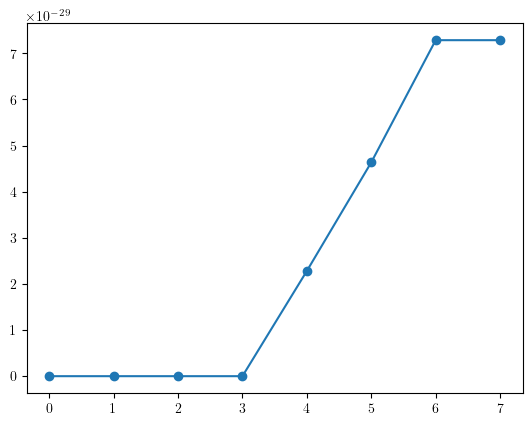

In [38]:
plt.plot(entagelement_entropy3(SS_),'o-')

In [39]:
def get_Ham(P,dt=1e-1):

    def get_hamill(i,j):
        if i==N-2 and j==N-1:
            return (-J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])) + ( - h_ * kronecker_product([I, sX]) )
        if j==i+1:
            return -J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])
        elif j==i+2:
            return -J2 * kronecker_product([sZ, sZ])
            
    
    H_list=[]
    U_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    for i in range(len(P)):
        H_=[]
        U_=[]
        for j in range(len(P[i])):
            k,l=P[i][j]
            H_bond=get_hamill(k,l)
            H_bond=np.reshape(H_bond, [d, d, d, d])
            U_.append(expm(-1j * dt * H_bond.reshape(d**2, d**2)).reshape(d, d, d, d))
            H_.append(H_bond)
        H_list.append(H_)
        U_list.append(U_)
    
    return H_list, U_list

def evolve_hamiltonian_chain(MPS_left,SS,P,U_gates,P_rev,U_gates_rev):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    for i in range(len(P)):
        for j in range(len(P[i])):
            k,l=P[i][j]
            # print((k,l))
            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 
        # print('going back')
        for j in range(len(P[i])-1,0,-1):
            k,l=P[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
    # print("fed")

    # print(len(P_rev))
    for i in range(len(P_rev)):
        
        for j in range(len(P_rev[i])-1-1,-1,-1):#range(0,len(P_rev[i])-1):
            k,l=P_rev[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
            
        for j in range(len(P_rev[i])):
            k,l=P_rev[i][j]
            # print((k,l))
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates_rev[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 

            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
        # print('going back')   
    
    
    return MPS_left, SS

def energy_chain1(MPS_left,SS,P,gates):
    MPS_left=MPS_left.copy()
    SS=SS.copy()
    results=[]
    for i in range(len(P)):
        for j in range(len(P[i])):
            k,l=P[i][j]
            # print((k,l))
            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            expectation=(ncon([A, A.conj(), B, B.conj(), np.diag(SS[l]**2), gates[i][j]], [[1, 2, 3], [1, 6, 7], [3,4,5], [7,8,9], [5,9], [6,8,2,4]]))
            results.append(expectation)
            
        # print('going back')
        for j in range(len(P[i])-1,0,-1):
            k,l=P[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
    # print("fed")    
    
    return results

In [40]:
P_nn=[[(i,i+1) for i in range(N-1)]]
H_nn,_=get_Ham(P_nn)
H_nn=H_nn[0]

In [41]:
P=[]
for i in range (N-1):
    P_=[]
    for j in range(i+1,i+3):
        if j<N:
            P_.append((i,j))
    P.append(P_)

P_rev=[]
P_=list(reversed(P))
for i in range(len(P)):
    P_rev.append(list(reversed(P_[i])))

In [42]:
E0=grd_state_energy
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]

In [43]:
# numiter = 100
# dt=0.01

# H_bonds,U_bonds=get_Ham(P,dt/2)
# H_bonds_rev,U_bonds_rev=get_Ham(P_rev,dt/2)

# for t in range (numiter):
    
#     MPS_,SS_=evolve_hamiltonian_chain(MPS_,SS_,P,U_bonds,P_rev,U_bonds_rev)

#     Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
#     Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
#     Entropy.append(entagelement_entropy3(SS_)[N//2])

#     # print("agberge")

    
#     energyMPS=np.sum(get_expectations_left(MPS_,SS_,H_nn))
#     Energy.append(energyMPS)
#     energyMPS=np.sum(energy_chain1(MPS_,SS_,P,H_bonds))
    
#     print(t*dt,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)

In [44]:
def get_Ham(P,dt=1e-1):

    def get_hamill(i,j):
        if i==N-2 and j==N-1:
            return (-J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])) + ( - h_ * kronecker_product([I, sX]) )
        if j==i+1:
            return -J1 * kronecker_product([sZ, sZ]) - h_ * kronecker_product([sX, I])
        elif j==i+2:
            return -J2 * kronecker_product([sZ, sZ])
        else:
            return kronecker_product([I*0.0, I*0.0])
            
    
    H_list=[]
    U_list=[]

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])

    for i in range(len(P)):
        H_=[]
        U_=[]
        for j in range(len(P[i])):
            k,l=P[i][j]
            H_bond=get_hamill(k,l)
            H_bond=np.reshape(H_bond, [d, d, d, d])
            U_.append(expm(-1j * dt * H_bond.reshape(d**2, d**2)).reshape(d, d, d, d))
            H_.append(H_bond)
        H_list.append(H_)
        U_list.append(U_)
    
    return H_list, U_list

In [45]:
P_nn=[[(i,i+1) for i in range(N-1)]]
H_nn,_=get_Ham(P_nn)
H_nn=H_nn[0]

In [46]:
P=[]
for i in range (N-1):
    P_=[]
    for j in range(i+1,i+4):
        if j<N:
            P_.append((i,j))
    P.append(P_)

P_rev=[]
P_=list(reversed(P))
for i in range(len(P)):
    P_rev.append(list(reversed(P_[i])))
P_rev

[[(7, 8)],
 [(6, 8), (6, 7)],
 [(5, 8), (5, 7), (5, 6)],
 [(4, 7), (4, 6), (4, 5)],
 [(3, 6), (3, 5), (3, 4)],
 [(2, 5), (2, 4), (2, 3)],
 [(1, 4), (1, 3), (1, 2)],
 [(0, 3), (0, 2), (0, 1)]]

In [47]:
E0=grd_state_energy
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]

In [48]:
# numiter = 100
# dt=0.01

# H_bonds,U_bonds=get_Ham(P,dt/2)
# H_bonds_rev,U_bonds_rev=get_Ham(P_rev,dt/2)

# for t in range (numiter):
    
#     MPS_,SS_=evolve_hamiltonian_chain(MPS_,SS_,P,U_bonds,P_rev,U_bonds_rev)

#     Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ)[N//2])
#     Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX)[N//2])
#     Entropy.append(entagelement_entropy3(SS_)[N//2])

#     # print("agberge")

    
#     # energyMPS=np.sum(energy_chain(MPS_,SS_,P,H_bonds,[],[]))
#     energyMPS=np.sum(get_expectations_left(MPS_,SS_,H_nn))
#     Energy.append(energyMPS)
#     energyMPS=np.sum(energy_chain1(MPS_,SS_,P,H_bonds))
    
#     print(t*dt,"   ",fidelity2(MPS_,MPS_),energyMPS,(energyMPS-E0)/E0)

######################################################################################################################################

MAIN: For rydberg atoms

In [49]:
N=22
d = 2
chi = 50
A = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A[0,0,0]=1
A_edge_R[0,0,0]=1
A_edge_L[0,0,0]=1


MPS=[]
for i in range(N):
    if i==0:
        MPS.append(A_edge_L)
    elif i==N-1:
        MPS.append(A_edge_R)
    else:
        MPS.append(A)
MPS[0].shape

MPS_left,SS=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [50]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,0,0]=1
A_even2[0,1,0]=1

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_Z1,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [51]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,1,0]=1 # changed
A_even2[0,0,0]=1 # changed

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_Z2,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [52]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,0,0]=1/np.sqrt(2)
A_even1[0,1,0]=1/np.sqrt(2)
A_even2[0,0,0]=1/np.sqrt(2)
A_even2[0,1,0]=1/np.sqrt(2)

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_Z,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [53]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
Ao = np.zeros([chi, d, chi], dtype=np.complex64)
Ae = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

Ae[0,0,0]=0
Ae[0,0,1]=1/np.sqrt(2)
Ae[0,1,0]=1/np.sqrt(2)
Ae[0,1,1]=0

Ao[0,0,0]=1
Ao[1,0,0]=0
Ao[0,1,0]=0
Ao[1,1,0]=1

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_odd)
    if i!=(N)//3-1-1:
        MPS.append(Ae)
        MPS.append(Ao)

# MPS=[Ao if i%2!=0 else Ae for i in range (N)]



MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_S,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [54]:
A_odd = np.zeros([chi, d, chi], dtype=np.complex64)
A_exc = np.zeros([chi, d, chi], dtype=np.complex64)
A_even1 = np.zeros([chi, d, chi], dtype=np.complex64)
A_even2 = np.zeros([chi, d, chi], dtype=np.complex64)
A_edge_R = np.zeros([chi, d, 1], dtype=np.complex64)
A_edge_L = np.zeros([1, d, chi], dtype=np.complex64)

A_odd[0,0,0]=1
A_exc[0,1,0]=1

A_edge_R[0,1,0]=1
A_edge_L[0,1,0]=1

A_even1[0,0,0]=1
A_even2[0,0,0]=1

MPS=[]

MPS.append(A_edge_L)
MPS.append(A_odd)
MPS.append(A_odd)

for i in range(0,(N)//3-1):
    # print(i)
    MPS.append(A_exc)
    if i!=(N)//3-1-1:
        MPS.append(A_even1)
        MPS.append(A_even2)


MPS.append(A_odd)
MPS.append(A_odd)
MPS.append(A_edge_R)

MPS_S2,_=left_canonical_form(MPS)

check [1.+0.j] [[1.+0.j]]


In [55]:
def get_Ham_Ryd(P,t,dt=1e-1):

    omega,delta=parameter(t,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge)

    Vnn=12.5*omega_max
    Vh=0.4*omega_max
    Vd=Vh/2.37
    # only 0.4 and 0.2 work for now. 0.35 and /2.37 doesnt work

    # WRONGGG; works but the probabilities are lower
    ## double to convert sum over all pair into forward count only
    # Vnn=2.0*Vnn
    # Vh=2.0*Vh
    # Vd=2.0*Vd

    sX = np.array([[0, 1.], [1., 0]])
    sY = np.array([[0, -1j], [1j, 0]])
    sZ = np.array([[1., 0], [0, -1.]])
    I=np.array([[1., 0.], [0., 1.]])
    nZ=-0.5*(sZ-I)

    def get_hamill(i,j):      
        if i==N-2 and j==N-1: # last bond: i in bottion
            return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ])) + (omega/2 * kronecker_product([I, sX]) - delta * kronecker_product([I, nZ]))
        if j==i+1:
            return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
        top=[q+1 for q in range(0,N-1,3)]
        middle=[q for q in range(0,N-1,3)]
        bottom=[q+2 for q in range(0,N-1,3)]
        if i in middle:
            # if j==i+1:
            #     return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
            if j==i+2:
                return (Vnn * kronecker_product([nZ, nZ]))
            elif j==i+3:
                return (Vh * kronecker_product([nZ, nZ]))
        if i in top:
            # if j==i+1:
            #     return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
            if j==i+2:
                return (Vnn * kronecker_product([nZ, nZ]))
            elif j==i+3:
                return (Vh * kronecker_product([nZ, nZ]))
            elif j==i+4:
                return (Vd * kronecker_product([nZ, nZ]))
        if i in bottom:
            # if j==i+1:
            #     return (omega/2 * kronecker_product([sX, I]) - delta * kronecker_product([nZ, I]) + Vnn * kronecker_product([nZ, nZ]))
            if j==i+2:
                return (Vd * kronecker_product([nZ, nZ]))
            elif j==i+3:
                return (Vh * kronecker_product([nZ, nZ]))            
    
    H_list=[]
    U_list=[]

    for i in range(len(P)):
        H_=[]
        U_=[]
        for j in range(len(P[i])):
            k,l=P[i][j]
            H_bond=get_hamill(k,l)
            H_bond=np.reshape(H_bond, [d, d, d, d])
            U_.append(expm(-1j * dt * H_bond.reshape(d**2, d**2)).reshape(d, d, d, d))
            H_.append(H_bond)
        H_list.append(H_)
        U_list.append(U_)
    
    return H_list, U_list

def evolve_hamiltonian_chain_Ryd(MPS_left,SS,P,P_rev,t,dt):
    MPS_left=MPS_left.copy()
    SS=SS.copy()

    # _,U_gates=get_Ham_Ryd(P,t,dt/2)
    # _,U_gates_rev=get_Ham_Ryd(P_rev,t,dt/2)

    _,U_gates=get_Ham_Ryd(P,t,dt)
    P_rev=[]
    
    for i in range(len(P)):
        for j in range(len(P[i])):
            k,l=P[i][j]
            # print((k,l))
            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 
        # print('going back')
        for j in range(len(P[i])-1,0,-1):
            k,l=P[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
    # print("fed")

    # print(len(P_rev))
    for i in range(len(P_rev)):
        
        for j in range(len(P_rev[i])-1-1,-1,-1):#range(0,len(P_rev[i])-1):
            k,l=P_rev[i][j]
            # print((k,l))
            A=MPS_left[l-2]
            B=MPS_left[l-1]
            # print(A.shape)
            A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
            # print(A.shape)
            MPS_left[l-2]=A
            MPS_left[l-1]=B  
            
        for j in range(len(P_rev[i])):
            k,l=P_rev[i][j]
            # print((k,l))
            
            A=MPS_left[l-1]
            B=MPS_left[l]
            A,SS[l-1],B=apply_gate_MPS_left(A,B,SS[l],U_gates_rev[i][j])
            MPS_left[l-1]=A
            MPS_left[l]=B 

            if l>k+1:
                # print('swap')
                A=MPS_left[l-2]
                B=MPS_left[l-1]
                # print(A.shape)
                
                A,SS[l-2],B=apply_gate_MPS_left(A,B,SS[l-1],Swap)
                # print(A.shape)
                MPS_left[l-2]=A
                MPS_left[l-1]=B  
        # print('going back')   
    
    
    return MPS_left, SS

0.10964158361028378

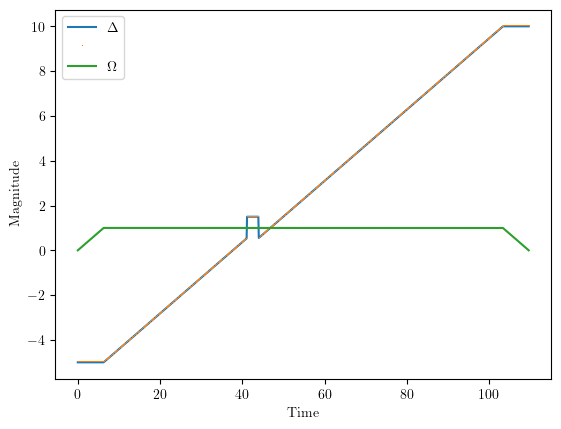

In [57]:
omega_max=1
delta_i=0.55*omega_max
delta_q=1.5*omega_max
T_q=0.45*2*np.pi/omega_max
delta_min=-5*omega_max
delta_max=10*omega_max

Slope_R=1
Slope_R_edge=1
R=omega_max**2/(2*np.pi)
Ti=(delta_i-delta_min)/(Slope_R*R)+omega_max/(Slope_R_edge*R)
Tff=(delta_max-delta_i)/(Slope_R*R)+(Ti+T_q)
T_final=Tff+omega_max/(Slope_R_edge*R)

t=np.linspace(0,T_final,1000)
omega,delta=parameter(t,omega_max,delta_i,delta_q,T_q,delta_min,delta_max,Slope_R,Slope_R_edge)
plt.plot(t,delta,',-')
plt.plot(t,delta,',')
plt.plot(t,omega)
plt.legend([r"$\Delta$",None,r"$\Omega$"])
plt.xlabel("Time")
plt.ylabel("Magnitude")

numiter = 1000
dt=T_final/numiter
dt

Text(0, 0.5, 'Magnitude')

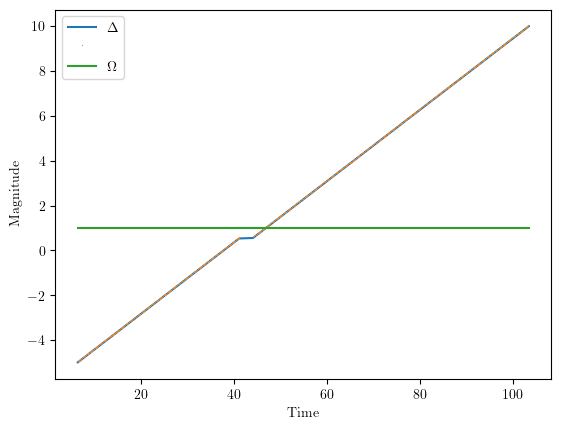

In [58]:
I_map=np.where(((t>omega_max/(Slope_R_edge*R)) & (t<Ti)) | ((t>Ti+T_q) & (t<Tff)))
plt.plot(t[I_map],delta[I_map],',-')
plt.plot(t[I_map],delta[I_map],',')
plt.plot(t[I_map],omega[I_map])
plt.legend([r"$\Delta$",None,r"$\Omega$"])
plt.xlabel("Time")
plt.ylabel("Magnitude")

In [59]:
P=[]
top=[q+1 for q in range(0,N,3)]
middle=[q for q in range(0,N,3)]
bottom=[q+2 for q in range(0,N,3)]
if N-1 not in middle:
    raise Exception("ERRROOOR")
for i in range (N-1):
    P_=[]
    if i in top:
        i_final=i+1+4
    elif i in middle:
        i_final=i+1+3
    else:
        i_final=i+1+3
    for j in range(i+1,i_final):
        if j<N:
            P_.append((i,j))
    P.append(P_)

P_rev=[]
P_=list(reversed(P))
for i in range(len(P)):
    P_rev.append(list(reversed(P_[i])))
P

[[(0, 1), (0, 2), (0, 3)],
 [(1, 2), (1, 3), (1, 4), (1, 5)],
 [(2, 3), (2, 4), (2, 5)],
 [(3, 4), (3, 5), (3, 6)],
 [(4, 5), (4, 6), (4, 7), (4, 8)],
 [(5, 6), (5, 7), (5, 8)],
 [(6, 7), (6, 8), (6, 9)],
 [(7, 8), (7, 9), (7, 10), (7, 11)],
 [(8, 9), (8, 10), (8, 11)],
 [(9, 10), (9, 11), (9, 12)],
 [(10, 11), (10, 12), (10, 13), (10, 14)],
 [(11, 12), (11, 13), (11, 14)],
 [(12, 13), (12, 14), (12, 15)],
 [(13, 14), (13, 15), (13, 16), (13, 17)],
 [(14, 15), (14, 16), (14, 17)],
 [(15, 16), (15, 17), (15, 18)],
 [(16, 17), (16, 18), (16, 19), (16, 20)],
 [(17, 18), (17, 19), (17, 20)],
 [(18, 19), (18, 20), (18, 21)],
 [(19, 20), (19, 21)],
 [(20, 21)]]

In [60]:
MPS_=MPS_left.copy()
SS_=SS.copy()
Energy=[]
Entropy=[]
Sz_expect=[]
Sx_expect=[]
Nz_expect=[]
Prob_Z=[]
Prob_Z1=[]
Prob_Z2=[]
Prob_S=[]
Prob_S2=[]

In [5197]:
numiter = 1000
dt=T_final/numiter
print(dt)

for t in np.arange(0,T_final,dt):
    
    MPS_,SS_=evolve_hamiltonian_chain_Ryd(MPS_,SS_,P,P_rev,t,dt)

    Sz_expect.append(apply_single_operator_left(MPS_,SS_,sZ))
    Sx_expect.append(apply_single_operator_left(MPS_,SS_,sX))
    Nz_expect.append(apply_single_operator_left(MPS_,SS_,nZ))
    Entropy.append(entagelement_entropy3(SS_))
    Prob_Z.append(fidelity2(MPS_,MPS_Z))
    Prob_Z1.append(fidelity2(MPS_,MPS_Z1))
    Prob_Z2.append(fidelity2(MPS_,MPS_Z2))
    Prob_S.append(fidelity2(MPS_,MPS_S))
    Prob_S2.append(fidelity2(MPS_,MPS_S2))

    # energyMPS=np.sum(get_expectations_left(MPS_,SS_,H_nn))
    # Energy.append(energyMPS)
    # energyMPS=np.sum(energy_chain1(MPS_,SS_,P,H_bonds))
    
    print(int(t/dt),"   ",fidelity2(MPS_,MPS_))

0.13
176     (1.0000000000000018-2.168404344971009e-19j)
177     (0.9999999999999996+1.734723475976807e-18j)
178     (1.0000000000000004-8.673617379884035e-18j)
179     (1.0000000000000073+1.0408340855860843e-17j)
180     (1.0000000000000009+6.938893903907228e-18j)
181     (0.9999999999999997+6.938893903907228e-18j)
182     (0.9999999999999982+0j)
183     (0.999999999999996+4.163336342344337e-17j)
184     (1.0000000000000007-5.117434254131581e-17j)
185     (0.9999999999999998+0j)
186     (0.9999999999999993+2.0816681711721685e-17j)
187     (0.9999999999999974-2.7755575615628914e-17j)
188     (0.9999999999999984+2.0816681711721685e-17j)
189     (0.9999999999999994-4.85722573273506e-17j)
190     (0.9999999999999974+3.469446951953614e-18j)
191     (1.000000000000005-6.071532165918825e-18j)
192     (0.9999999999999962-8.673617379884035e-19j)
193     (0.9999999999999974-4.336808689942018e-19j)
194     (1.0000000000000029+3.903127820947816e-18j)
195     (1.0000000000000002+1.9081958235744878

(0.0, 5.0)

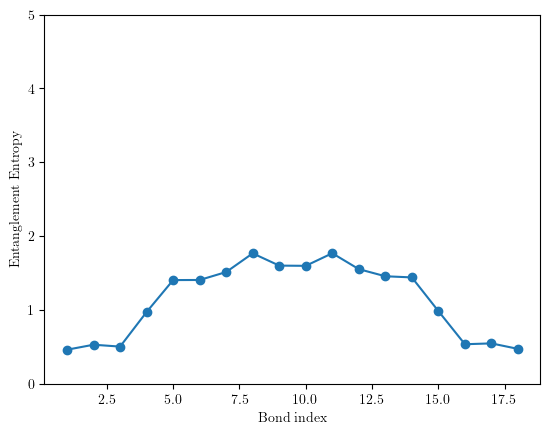

In [5079]:
Bond_idx=range(1,N)
plt.plot(Bond_idx,Entropy[-1],'o-')
plt.xlabel("Bond index")
plt.ylabel("Entanglement Entropy")
plt.ylim([0,5])

In [4889]:
def fidelity_truncate(MPS_B,chi_trun):
    
    MPS_B=MPS_B.copy()

    for i in range(len(MPS_B)):
        B=MPS_B[i]
        chi_L,_,chi_R=B.shape
        B=B.reshape(chi_L*d,chi_R)
        chi_R=min(chi_R,chi_trun)
        B=B[:,range(chi_R)]
        B=B.reshape(chi_L,chi_R*d)
        chi_L=min(chi_L,chi_trun)
        B=B[range(chi_L),:]
        B=B.reshape(chi_L,d,chi_R)
        MPS_B[i]=B
        # print()

    
    MPS_A=MPS_B.copy()
    for i in range(len(MPS_B)):
        MPS_B[i]=np.conj(MPS_B[i])    
        
        
        
    Norm=ncon([MPS_A[0],MPS_B[0]],[[1,2,-1],[1,2,-2]])
    for i in range(1,len(MPS_A)):
        Norm=ncon([Norm,MPS_A[i],MPS_B[i]],[[1,3],[1,2,-1],[3,2,-2]])
    return (ncon([Norm],[[1,1]]))

Text(0, 0.5, 'Fidelity')

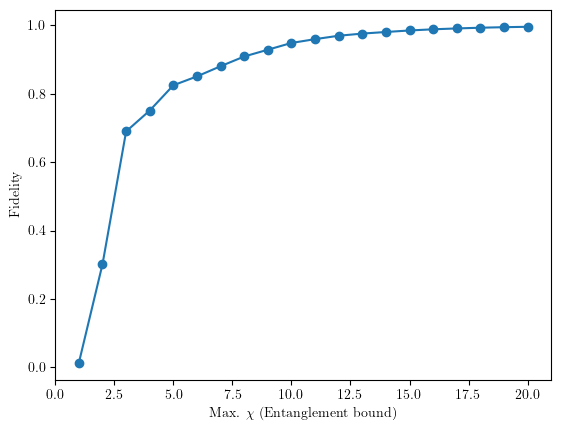

In [5080]:
chi_main=chi
MPS_main=MPS_.copy()
SS_main=SS_.copy()
max_chi=[]
Fidelity=[]
max_=21
for i in range(1,max_,1):
    chi=int(i)
    max_chi.append(chi)
    # MPS__temp,_=Normalized_left(MPS_main,SS_main)
    Fidelity.append(fidelity_truncate(MPS_main,chi))
chi=chi_main

plt.plot(max_chi,Fidelity,'o-')
plt.xlim([0,max_])
plt.xlabel(r"Max. $ \chi $ (Entanglement bound)")
plt.ylabel("Fidelity")

In [4240]:
# MPS___=MPS_.copy()
# SS___=SS_.copy()

In [4184]:
# MPS_=MPS___.copy()
# SS_=SS___.copy()

In [4138]:
# MPS_=Us.copy()
# SS_=SS.copy()

Text(0.5, 1.0, 'Sweep-quench-sweep')

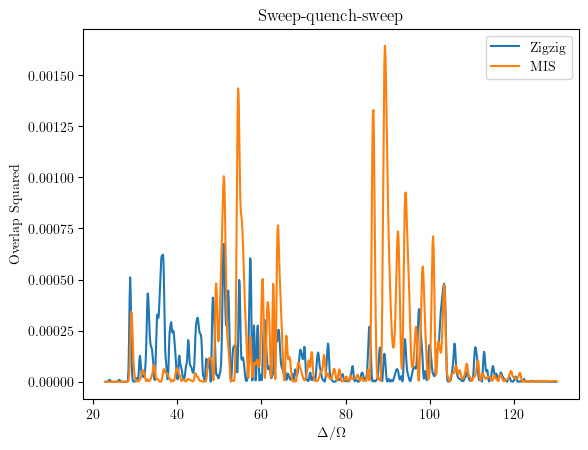

In [5198]:
x_=np.linspace(delta_min/omega_max, delta_max/omega_max,len(Prob_S))
plt.plot(np.arange(23,T_final,dt),(np.abs(np.array(Prob_S)))**2)
plt.plot(np.arange(23,T_final,dt),(np.abs(np.array(Prob_S2)))**2)
# plt.plot((np.array(Prob_Z))**2)
# plt.plot((np.array(Prob_Z1))**2)
# plt.plot((np.array(Prob_Z2))**2)
plt.xlabel(r"$\Delta / \Omega$")
plt.ylabel("Overlap Squared")
plt.legend(["Zigzig","MIS"])
plt.title("Sweep-quench-sweep")
# plt.title("Sweep")

In [4944]:
# plt.plot(Sz_expect)

In [5134]:
Nz_=[]
for i in range(len(Nz_expect)):
    Nz__=[]
    for j in range(0,N-1,3):
        Nz__.append(np.real(Nz_expect[i][j]))
        Nz__.append(np.real(Nz_expect[i][j+1]+Nz_expect[i][j+2]))
    Nz__.append(np.real(Nz_expect[i][-1]))
    Nz_.append(Nz__)
Nz_=np.array(Nz_)

0

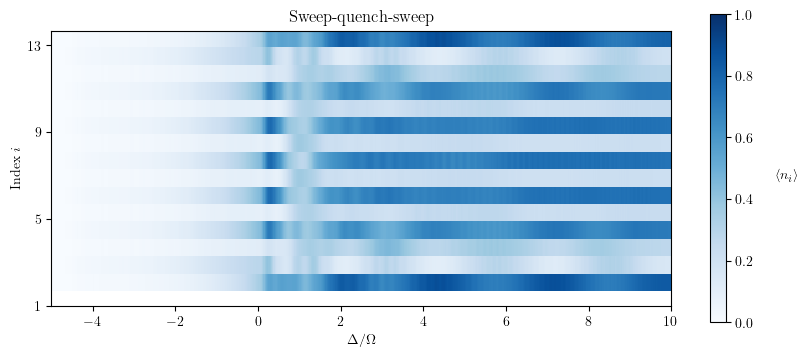

In [5138]:
plt.figure(figsize = (10,4))
plt.imshow((np.real(Nz_).T), interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.35, vmin=0, vmax=1, cmap='Blues')
c_bar=plt.colorbar()
c_bar.set_label(r"$ \langle n_i \rangle $", rotation=360, labelpad=25)
# y__ = np.array(range(1,N-4)) # the grid to which your data corresponds
# ny = y__.shape[0]
# no_labels = len(y__)#int(len(T_)/2) # how many labels to see on axis x
# step_y = (ny / (no_labels)) # step between consecutive labels
# y_positions = np.arange(0+step_y,ny+step_y/2,step_y) # pixel count at label position
# y_labels = y__#[::step_y] # labels you want to see
# y_labels = [int(y_labels[i]) for i in range(len(y_labels))]
# plt.yticks(y_positions, y_labels)

plt.xlabel(r"$\Delta / \Omega$")
plt.ylabel(r"Index $ i $")
plt.title("Sweep-quench-sweep")
plt.yticks([0,6,12,N-1],[1,5,9,13])#,[1,2,2,3,4,4,5,6,6,7,8,8,9,10,10,11,12,12,13])
# plt.title("Sweep")
0

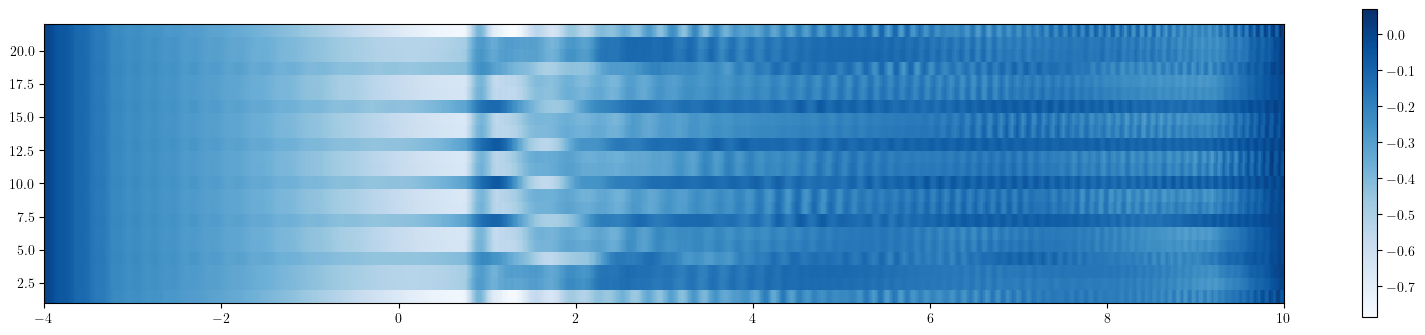

In [4941]:
plt.figure(figsize = (20,4))
plt.imshow(np.real(Sx_expect).T, interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.15, cmap='Blues')
plt.colorbar()

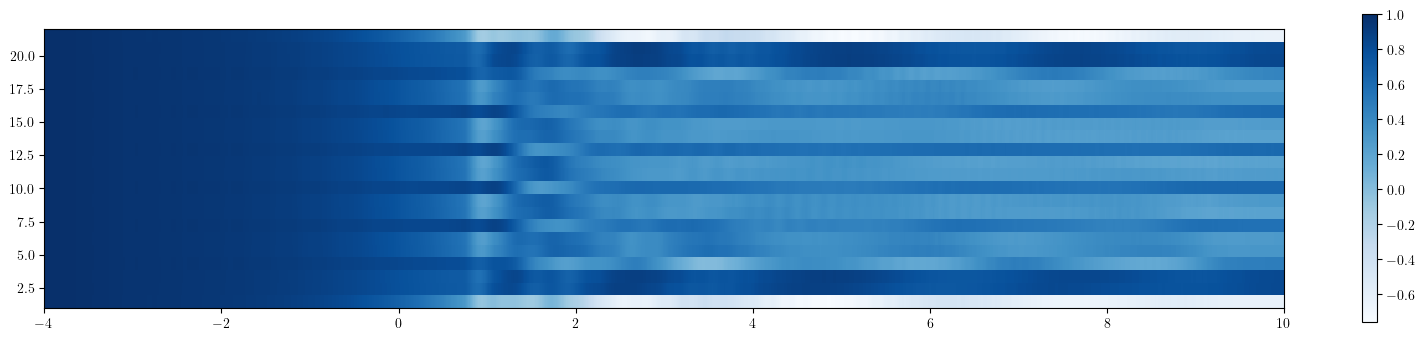

In [4942]:
plt.figure(figsize = (20,4))
plt.imshow(np.real(Sz_expect).T, interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.15, cmap='Blues')
plt.colorbar()

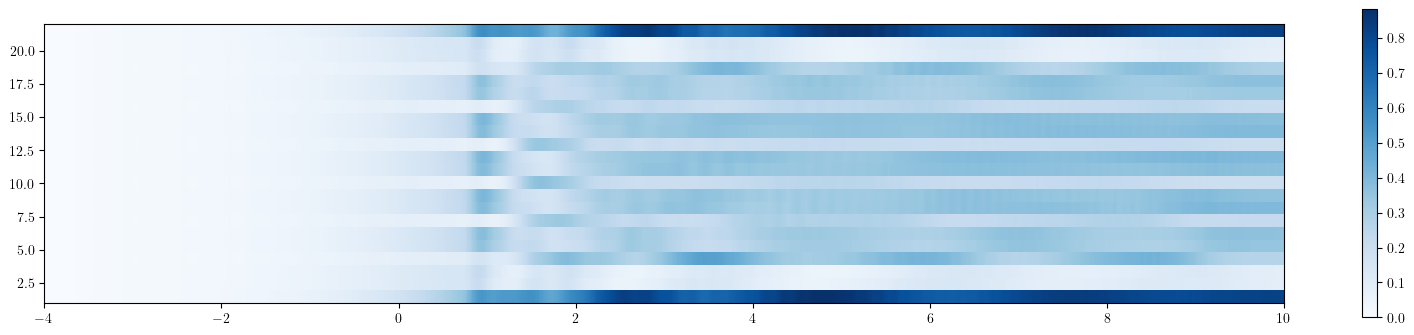

In [4943]:
plt.figure(figsize = (20,4))
plt.imshow(np.real(Nz_expect).T, interpolation='none',  extent = [delta_min/omega_max, delta_max/omega_max, 1, N], aspect = 0.15, cmap='Blues')
plt.colorbar()

In [5136]:
Nz_expect=Nz_expect22.copy()
Nz_=Nz_22.copy()

In [5108]:
Prob_S_sweep=Prob_S.copy()
Prob_S2_sweep=Prob_S2.copy()

In [5133]:
Nz_expect_sqs=Nz_expect22.copy()
Nz_sqs=Nz_22.copy()

In [5110]:
Nz_expect_sweep=Nz_expect.copy()
Nz_sweep=Nz_.copy()

In [5099]:
Prob_S_sqs=Prob_S.copy()
Prob_S2_sqs=Prob_S2.copy()

In [4946]:
Entropy22=Entropy.copy()
Nz_expect22=Nz_expect.copy()
Nz_22=Nz_.copy()
Fidelity22=Fidelity.copy()
Sx_expect22=Sx_expect.copy()
Sz_expect22=Sz_expect.copy()
MPS_22=MPS_.copy()
SS_22=SS_.copy()

In [4962]:
Entropy34=Entropy.copy()
Nz_expect34=Nz_expect.copy()
Nz_34=Nz_.copy()
Fidelity34=Fidelity.copy()
Sx_expect34=Sx_expect.copy()
Sz_expect34=Sz_expect.copy()
MPS_34=MPS_.copy()
SS_34=SS_.copy()

In [4979]:
Entropy46=Entropy.copy()
Nz_expect46=Nz_expect.copy()
Nz_46=Nz_.copy()
Fidelity46=Fidelity.copy()
Sx_expect46=Sx_expect.copy()
Sz_expect46=Sz_expect.copy()
MPS_46=MPS_.copy()
SS_46=SS_.copy()

In [4997]:
Entropy19=Entropy.copy()
Nz_expect19=Nz_expect.copy()
Nz_19=Nz_.copy()
Fidelity19=Fidelity.copy()
Sx_expect19=Sx_expect.copy()
Sz_expect19=Sz_expect.copy()
MPS_19=MPS_.copy()
SS_19=SS_.copy()

In [5013]:
Entropy25=Entropy.copy()
Nz_expect25=Nz_expect.copy()
Nz_25=Nz_.copy()
Fidelity25=Fidelity.copy()
Sx_expect25=Sx_expect.copy()
Sz_expect25=Sz_expect.copy()
MPS_25=MPS_.copy()
SS_25=SS_.copy()

In [5027]:
Entropy28=Entropy.copy()
Nz_expect28=Nz_expect.copy()
Nz_28=Nz_.copy()
Fidelity28=Fidelity.copy()
Sx_expect28=Sx_expect.copy()
Sz_expect28=Sz_expect.copy()
MPS_28=MPS_.copy()
SS_28=SS_.copy()

In [5040]:
Entropy31=Entropy.copy()
Nz_expect31=Nz_expect.copy()
Nz_31=Nz_.copy()
Fidelity31=Fidelity.copy()
Sx_expect31=Sx_expect.copy()
Sz_expect31=Sz_expect.copy()
MPS_31=MPS_.copy()
SS_31=SS_.copy()

1

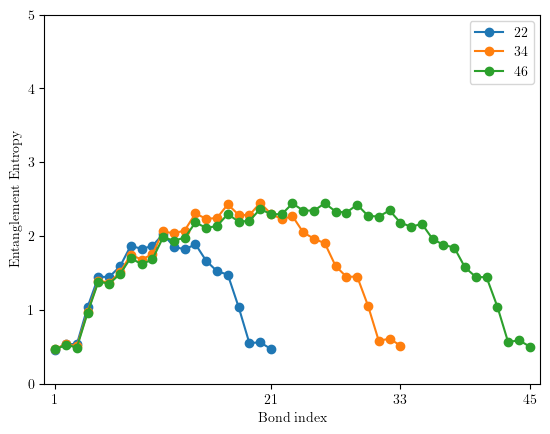

In [5052]:
# plt.plot(range(1,19),Entropy19[-1],'o-')
plt.plot(range(1,22),Entropy22[-1],'o-')
plt.plot(range(1,34),Entropy34[-1],'o-')
plt.plot(range(1,46),Entropy46[-1],'o-')
plt.xlabel("Bond index")
plt.ylabel("Entanglement Entropy")
plt.ylim([0,5])
plt.xlim([0,46])
plt.legend([22,34,46])
positions = [1, 21, 33, 45]
labels = ['1', '21', '33', '45']
plt.xticks(positions, labels)
1

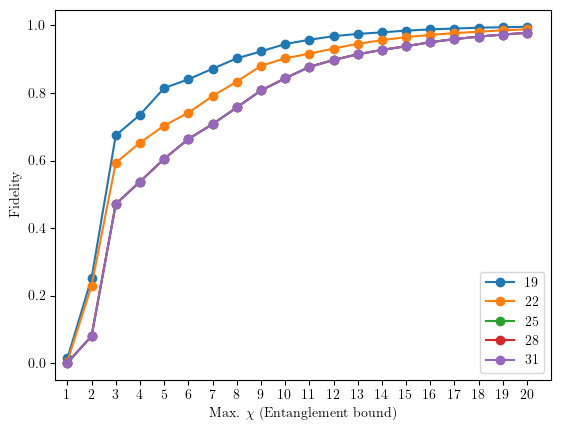

In [5047]:
max_=21
max_chi=range(1,max_,1)
plt.plot(max_chi,Fidelity19,'o-')
plt.plot(max_chi,Fidelity22,'o-')
plt.plot(max_chi,Fidelity25,'o-')
plt.plot(max_chi,Fidelity28,'o-')
plt.plot(max_chi,Fidelity31,'o-')
# plt.plot(max_chi,Fidelity34,'o-')
# plt.plot(max_chi,Fidelity46,'o-')
plt.xlim([0.5,max_])
plt.xticks(range(1,max_,1))
plt.xlabel(r"Max. $ \chi $ (Entanglement bound)")
plt.ylabel("Fidelity")
plt.legend([19,22,25,28,31],loc=4)

Text(0.5, 1.0, 'Sweep-quench-sweep')

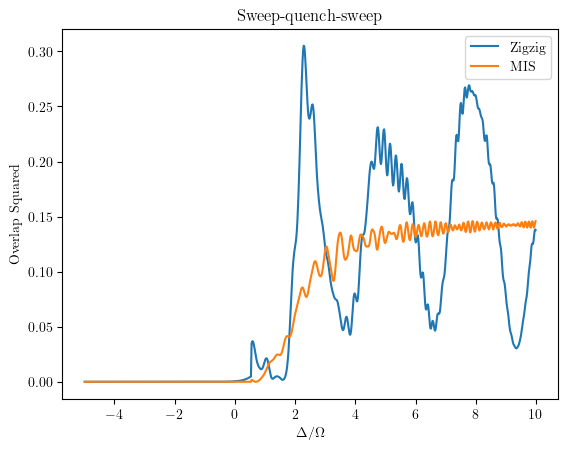

In [5100]:
x_=delta[I_map]/omega[I_map]
plt.plot(x_,((np.abs(np.array(Prob_S_sqs)))**2)[I_map])
plt.plot(x_,((np.abs(np.array(Prob_S2_sqs)))**2)[I_map])
plt.xlabel(r"$\Delta / \Omega$")
plt.ylabel("Overlap Squared")
plt.legend(["Zigzig","MIS"])
plt.title("Sweep-quench-sweep")
# plt.title("Sweep")

Text(0.5, 1.0, 'Sweep')

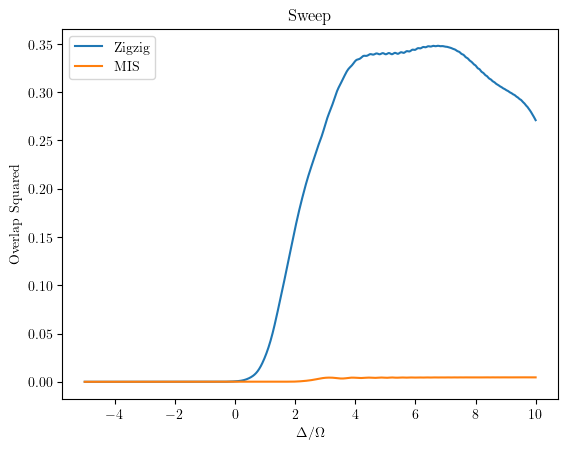

In [5132]:
x_=delta[I_map]/omega[I_map]
plt.plot(x_,((np.abs(np.array(Prob_S_sweep)))**2)[I_map])
plt.plot(x_,((np.abs(np.array(Prob_S2_sweep)))**2)[I_map])
plt.xlabel(r"$\Delta / \Omega$")
plt.ylabel("Overlap Squared")
plt.legend(["Zigzig","MIS"])
# plt.title("Sweep-quench-sweep")
plt.title("Sweep")